# Случайный и направленный поиск лучших гиперпараметров.

Большинство моделей содержат гиперпараметры, требующие подбора для наилучшей точности, такие как тип ядра в SVM и степень регуляризации.

Как вы думаете, почему нельзя подбирать гиперпараметры по обучающей выборке, на которой настраивались обычные параметры моделей?

Случайный поиск лучше поиска по сетке за счет более широкого перебора по пространству **важных** гиперпараметров:

<img src="grid and random search.png" width="75%">

# Загрузка датасета

In [12]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from time import time

In [13]:
import sklearn
from sklearn import datasets
import pandas as pd

In [14]:
data = datasets.fetch_openml(name='wdbc', version=1, parser='auto', data_home='datasets',
                          as_frame=True)

In [15]:
data.DESCR

'**Author**: William H. Wolberg, W. Nick Street, Olvi L. Mangasarian    \n**Source**: [UCI](https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(original)), [University of Wisconsin](http://pages.cs.wisc.edu/~olvi/uwmp/cancer.html) - 1995  \n**Please cite**: [UCI](https://archive.ics.uci.edu/ml/citation_policy.html)     \n\n**Breast Cancer Wisconsin (Diagnostic) Data Set (WDBC).** Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image. The target feature records the prognosis (benign (1) or malignant (2)). [Original data available here](ftp://ftp.cs.wisc.edu/math-prog/cpo-dataset/machine-learn/cancer/) \n\nCurrent dataset was adapted to ARFF format from the UCI version. Sample code ID\'s were removed.  \n\n! Note that there is also a related Breast Cancer Wisconsin (Original) Data Set with a different set of features, better known as [breast-w](https://www.openml.or

In [16]:
X=data.data
Y=data.target

In [17]:
X.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [18]:
len(X), len(X.columns)

(569, 30)

In [19]:
Y.head()

0    2
1    2
2    2
3    2
4    2
Name: Class, dtype: category
Categories (2, object): ['1', '2']

In [20]:
Y=Y.cat.rename_categories([0,1]).astype(int)

In [21]:
Y.unique()

array([1, 0])

In [22]:
Z=X.copy()
Z['Y']=Y

In [23]:
np.random.seed(0)
Z = Z.sample(frac=1).reset_index(drop=True)

In [24]:
from sklearn.model_selection import train_test_split

Z_train, Z_test, ind_train, ind_test = train_test_split(Z, np.arange(len(Z)), test_size=0.4, shuffle=True, random_state=0, stratify=Z['Y'])   # разделим в на обучение/тест в заданной пропорции

len(Z), len(Z_train), len(Z_test)

(569, 341, 228)

In [25]:
def XY_split(Z):
    '''Функция разбиения по признаки и отклики'''
    Y = Z['Y']
    X = Z.copy()
    X = X.drop('Y',axis=1)
    return X,Y

X_train, Y_train = XY_split(Z_train)
X_test, Y_test = XY_split(Z_test)
X, Y = XY_split(Z)

Будем классифицировать объекты методом SVM.

Гиперпараметры:
- `C`: выбор между точностью и простотой модели
- `kernel in ['linear', 'poly', 'rbf']`: тип ядра
- `degree`: степень полиномиального ядра
- `rbf`=$\frac{1}{2 \sigma^2}$: контролирует разброс Гауссова ядра

In [26]:
from sklearn.svm import SVC

In [27]:
N_TRIALS = 40  # число испытаний (эффективнее, когда делится на #ядер процессора)

# Случайный поиск в `sklearn`

In [28]:
from sklearn.model_selection import RandomizedSearchCV

from scipy.stats import uniform, randint, loguniform


distributions = dict(C=loguniform(1e-10, 1e4),
                     kernel=['linear', 'poly', 'rbf'],
                     degree=randint(0, 5),
                     gamma=uniform(0, 2))

model = SVC()
clf = RandomizedSearchCV(model, distributions, n_iter=N_TRIALS, cv=[[ind_train, ind_test]], n_jobs=-1, verbose=10, random_state=0)

In [29]:
start = time()
test = clf.fit(X.to_numpy(), Y.to_numpy())
random_search_time = time() - start
random_search_params = test.best_params_

Fitting 1 folds for each of 40 candidates, totalling 40 fits


In [ ]:
%time
test = clf.fit(X.to_numpy(), Y.to_numpy())
test.best_score_, test.best_params_

Fitting 1 folds for each of 40 candidates, totalling 40 fits


(0.9473684210526315,
 {'C': 45.360500482124316,
  'degree': 0,
  'gamma': 1.957236684465528,
  'kernel': 'linear'})

Проверим инициализацию лучшими параметрами:

In [30]:
model = SVC(**test.best_params_)
model.fit(X_train, Y_train)
display(model)

random_search_accuracy = (model.predict(X_test) == Y_test).mean()
print(f'Accuracy: {random_search_accuracy:.3f}')

SVC(C=45.360500482124316, degree=0, gamma=1.957236684465528, kernel='linear')

Accuracy: 0.947


# Направленный поиск в Optuna

In [31]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.4 MB/s eta 0:00:00


In [32]:
import optuna   # установка в conda: conda install -c conda-forge optuna

Теперь подбор гиперпараметров будем осуществлять с помощью библиотеки optuna.

Рассмотрим основные объекты:

Если нужно передавать дополнительные аргументы в `objective` - см. в [документации](https://optuna.readthedocs.io/en/stable/faq.html#objective-func-additional-args).

In [34]:
# FYI: Objective functions can take additional arguments
# ().
def objective(trial):

    kernel = trial.suggest_categorical("kernel", ["linear", "poly", "rbf"])

    c = trial.suggest_float("C", 1e-10, 1e4, log=True)
    degree = 3
    gamma = 'scale'
    if kernel == "poly":
        degree = trial.suggest_int("degree", 0, 5)
    if kernel == "rbf":
        gamma = trial.suggest_float("gamma", 0, 2)

    model = SVC(C=c, kernel=kernel, degree=degree, gamma=gamma)

    model.fit(X_train, Y_train)
    accuracy = (model.predict(X_test) == Y_test).mean()

    return accuracy

Функция objective фактически должна содержать в себе весь пайплайн построения, обучения и применения модели, и должна возвращать некоторое число - нашу метрику оценивания модели.
В качестве метрики можно использовать любое число.

Отличие objective от простого пайплайна модели в том, что эта функция принимает на вход аргумент trial, который можно использовать для получения **некоторых заранее неизвестных значений** гиперпараметров нашей модели из заранее определенного диапазона.

С помощью функций trial.suggest_int, trial.suggest_float и других мы можем получить некоторое значение параметра, которое используем дальше в пайплайне построения модели.

In [35]:
sampler = optuna.samplers.TPESampler(seed=0)  # Зафиксируем тип случайности для воспроизводимости. Необязательно в общем случае.
study = optuna.create_study(sampler=sampler, direction="maximize")

[I 2023-11-06 00:24:13,453] A new study created in memory with name: no-name-78c83441-2ade-492a-9dc8-2559f6dd51e1


study - объект класса Study в библиотеке optuna -- определяет ход нашего "исследования".

Параметры позволяют определить, в какую сторону нужно оптимизировать метрику нашего objective, какой sampler и pruner использовать.

sampler - способ, которым будут выбираться параметры, получаемые с помощью trial.suggest_int и аналогичных функций. Базово используется байесовский TPESampler, подбирающий гиперпараметры по условным распределениям гиперпараметров. Также часто используются GridSampler - подбор параметров по сетке (декартово произведение задаваемых множеств параметров) - и RandomSampler - случайные значения параметров из заданных диапазонов.

"Исследование" запускается с помощью метода optimize:

In [ ]:
%time study.optimize(objective, n_trials=N_TRIALS, n_jobs=-1) # n_jobs=-1 чтобы использовать все ядра
print(study.best_trial)

[I 2023-10-17 13:16:00,490] Trial 1 finished with value: 0.8991228070175439 and parameters: {'kernel': 'poly', 'C': 1.2738026522726107, 'degree': 2}. Best is trial 1 with value: 0.8991228070175439.
[I 2023-10-17 13:16:00,501] Trial 0 finished with value: 0.8508771929824561 and parameters: {'kernel': 'poly', 'C': 0.028952506815487538, 'degree': 1}. Best is trial 1 with value: 0.8991228070175439.
[I 2023-10-17 13:16:00,581] Trial 2 finished with value: 0.6271929824561403 and parameters: {'kernel': 'poly', 'C': 1.9049137134942349e-06, 'degree': 1}. Best is trial 1 with value: 0.8991228070175439.
[I 2023-10-17 13:16:00,588] Trial 3 finished with value: 0.6271929824561403 and parameters: {'kernel': 'poly', 'C': 6.64914432114095e-10, 'degree': 5}. Best is trial 1 with value: 0.8991228070175439.
[I 2023-10-17 13:16:00,627] Trial 4 finished with value: 0.8991228070175439 and parameters: {'kernel': 'linear', 'C': 3.7480873832151823e-07}. Best is trial 1 with value: 0.8991228070175439.
[I 2023-1

CPU times: user 53.8 s, sys: 39.6 ms, total: 53.8 s
Wall time: 39.7 s
FrozenTrial(number=18, state=TrialState.COMPLETE, values=[0.9517543859649122], datetime_start=datetime.datetime(2023, 10, 17, 13, 16, 18, 297966), datetime_complete=datetime.datetime(2023, 10, 17, 13, 16, 24, 704150), params={'kernel': 'linear', 'C': 3.095559327807222}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'kernel': CategoricalDistribution(choices=('linear', 'poly', 'rbf')), 'C': FloatDistribution(high=10000.0, log=True, low=1e-10, step=None)}, trial_id=18, value=None)


Проверим инициализацию лучшими параметрами:

In [36]:
start = time()
study.optimize(objective, n_trials=N_TRIALS, n_jobs=-1)
optuna_time = time() - start
optuna_params = study.best_params

[I 2023-11-06 00:24:19,039] Trial 0 finished with value: 0.6271929824561403 and parameters: {'kernel': 'poly', 'C': 6.097663776461472e-09, 'degree': 3}. Best is trial 0 with value: 0.6271929824561403.
[I 2023-11-06 00:24:19,065] Trial 1 finished with value: 0.6271929824561403 and parameters: {'kernel': 'rbf', 'C': 231.6316518217722, 'gamma': 1.2141767041946305}. Best is trial 0 with value: 0.6271929824561403.
[I 2023-11-06 00:24:19,091] Trial 3 finished with value: 0.9385964912280702 and parameters: {'kernel': 'linear', 'C': 0.0017477488775533992}. Best is trial 3 with value: 0.9385964912280702.
[I 2023-11-06 00:24:19,111] Trial 2 finished with value: 0.6271929824561403 and parameters: {'kernel': 'rbf', 'C': 764.9113251286924, 'gamma': 1.4121547202313223}. Best is trial 3 with value: 0.9385964912280702.
[I 2023-11-06 00:24:19,137] Trial 5 finished with value: 0.6271929824561403 and parameters: {'kernel': 'linear', 'C': 1.3672280006859718e-09}. Best is trial 3 with value: 0.938596491228

In [37]:
model = SVC(**study.best_params)
model.fit(X_train, Y_train)
display(model)
optuna_accuracy = (model.predict(X_test) == Y_test).mean()
print(f'Accuracy: {optuna_accuracy:.3f}')

SVC(C=1.2991743513633927, kernel='linear')

Accuracy: 0.952


Видим, что времени на поиск затрачено меньше (`Wall time`), а результирующая точность (`Accuracy`) - выше.

#Scikit-optimize (skopt)

Scikit-optimize (часто называемая `skopt`) - это библиотека для оптимизации гиперпараметров на языке Python. Она построена на основе библиотеки `scikit-learn` и предназначена для взаимодействия с API `scikit-learn`, что делает ее популярным выбором для настройки гиперпараметров моделей `scikit-learn`.

In [38]:
!pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 2.3 MB/s eta 0:00:00


##BayesSearchCV

`BayesSearchCV` - это реализация байесовской оптимизации гиперпараметров. Вместо полного перебора гиперпараметров, как в GridSearch, или случайного, как в RandomSearch, байесовская оптимизация строит вероятностную модель целевой функции и использует ее для выбора наиболее оптимальных гиперпараметров для оценки в настоящей целевой функции.

Ниже приводится описание шагов:

1. **Определение пространства поиска гиперпараметров**: Мы определяем диапазон и тип (например, вещественный, целочисленный, категориальный) каждого гиперпараметра, который мы хотим оптимизировать.
2. **Инициализация `BayesSearchCV`**: Мы создаем экземпляр `BayesSearchCV`, указывая:
   - `estimator`: Модель, которую мы хотим оптимизировать.
   - `search_spaces`: Определенное нами пространство поиска гиперпараметров.
   - `n_iter`: Количество итераций для поиска.
   - `cv`: Стратегия кросс-валидации. Здесь мы используем предопределенные индексы train/test.
   - `n_jobs`: Количество параллельно выполняемых заданий. `-1` означает использование всех доступных процессоров.
   - `random_state`: Начальное состояние для воспроизводимости.
3. **Обучение и поиск**: Вызов `fit` приводит к тому, что `BayesSearchCV` ищет наилучшие гиперпараметры с помощью байесовской оптимизации. После обучения наилучшие гиперпараметры могут быть получены с помощью атрибута `best_params_`.

In [39]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer


search_space = {
    'C': Real(1e-10, 1e4, prior='log-uniform'),
    'kernel': Categorical(['linear', 'poly', 'rbf']),
    'degree': Integer(0, 5),
    'gamma': Real(0, 2)
}

bayes_search = BayesSearchCV(
    estimator = model,
    search_spaces = search_space,
    n_iter=N_TRIALS,
    cv=[[ind_train, ind_test]],
    n_jobs=-1,
    verbose=10,
    random_state=0
)

In [ ]:
%time  search = bayes_search.fit(X.to_numpy(), Y.to_numpy())
search.best_score_, search.best_params_

Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fi

(0.956140350877193,
 OrderedDict([('C', 7.10881567460541e-08),
              ('degree', 2),
              ('gamma', 1.5664409648278272),
              ('kernel', 'poly')]))

In [40]:
start = time()
search = bayes_search.fit(X.to_numpy(), Y.to_numpy())
bayes_search_time = time() - start
bayes_search_params = search.best_params_

Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fi

In [41]:
model = SVC(**search.best_params_)
model.fit(X_train, Y_train)
display(model)

bayes_search_accuracy = (model.predict(X_test) == Y_test).mean()
print(f'Accuracy: {bayes_search_accuracy:.3f}')

SVC(C=7.10881567460541e-08, degree=2, gamma=1.5664409648278272, kernel='poly')

Accuracy: 0.956


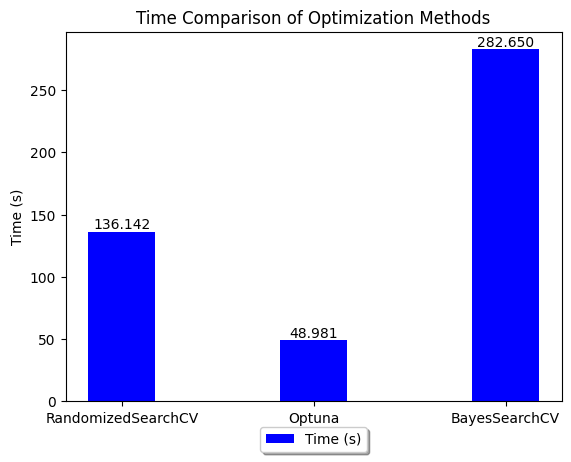

In [54]:
labels = ['RandomizedSearchCV', 'Optuna', 'BayesSearchCV']
times = [random_search_time, optuna_time, bayes_search_time]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
bars = ax.bar(x, times, width, label='Time (s)', color='blue')
ax.set_ylabel('Time (s)')
ax.set_title('Time Comparison of Optimization Methods')
ax.set_xticks(x)
ax.set_xticklabels(labels)

for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.3f}', va='bottom', ha='center')

# Place a legend below this subplot
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2)

plt.show()


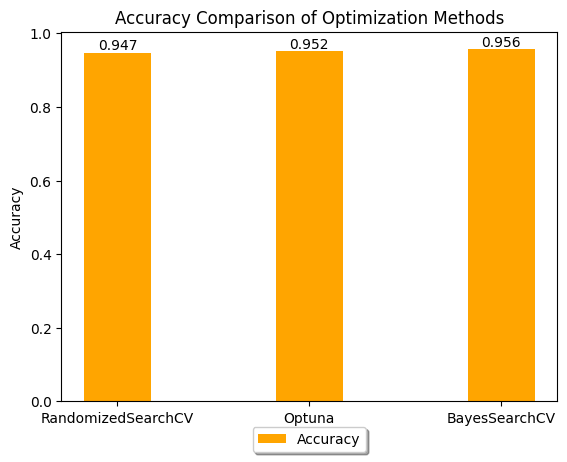

In [51]:
import matplotlib.pyplot as plt
import numpy as np

# Labels for the different optimization methods
labels = ['RandomizedSearchCV', 'Optuna', 'BayesSearchCV']

# Example time and accuracy data for the three methods
accuracies = [random_search_accuracy, optuna_accuracy, bayes_search_accuracy]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
bars = ax.bar(x, accuracies, width, label='Accuracy', color='orange')

ax.set_ylabel('Accuracy')
ax.set_title('Accuracy Comparison of Optimization Methods')
ax.set_xticks(x)
ax.set_xticklabels(labels)

# Adding the text on top of each bar
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.3f}', va='bottom', ha='center')

# Place a legend below this subplot
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2)

plt.show()



In [55]:
print(f"Best parameters for RandomizedSearchCV: {random_search_params}")
print(f"Best parameters for Optuna: {optuna_params}")
print(f"Best parameters for BayesSearchCV: {bayes_search_params}")

Best parameters for RandomizedSearchCV: {'C': 45.360500482124316, 'degree': 0, 'gamma': 1.957236684465528, 'kernel': 'linear'}
Best parameters for Optuna: {'kernel': 'linear', 'C': 1.2991743513633927}
Best parameters for BayesSearchCV: OrderedDict([('C', 7.10881567460541e-08), ('degree', 2), ('gamma', 1.5664409648278272), ('kernel', 'poly')])
